# 4. LSTM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1fEHXLhLjBIj_sCs4kuZa3WUyzvGn1rFH?usp=sharing)

3장에서는 Johns Hopkins University에서 제공하는 시계열 데이터를 지도학습용 데이터로 변환하는 과정을 실습했습니다. 이번 장에서는 LSTM을 사용하여 앞으로의 대한민국 코로나 확진자 수를 예측해보는 모델을 구축해보겠습니다.

4.1절과 4.2절에서는 대한민국 코로나 누적 확진자 수 데이터를 불러온 후, 데이터를 훈련용, 검증용, 시험용 데이터로 나누어 보겠습니다. 4.3절에서는 LSTM 모델을 정의하고 4.4절에서는 정의한 모델을 학습시켜 보겠습니다. 마지막으로 앞으로의 코로나 확진자 수에 대한 예측값을 확인해보겠습니다.

우선 기본적인 모듈들을 import 해줍니다.

`%matplotlib inline`은 notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것, `%config InlineBackend.figure_format='retina'`는 그래프의 해상도를 높여줍니다.






In [ ]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 4.1 데이터 다운로드


모델링 실습을 위해 대한민국 코로나 누적 확진자 
데이터를 불러오겠습니다. 2.1절에 나온 코드를 활용하겠습니다. 

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 6), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (24/24), done.
COVIDTimeSeries.zip is done!


## 4.2 데이터 전처리

3장에서 실습한 코드를 활용해 시계열 데이터를 지도학습용 데이터로 변형한 후 학습용, 검증용, 시험용 데이터로 분리하겠습니다. 그리고 훈련용 데이터의 통계량을 활용해 스케일링을 진행하겠습니다. 

In [ ]:
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

#학습용, 검증용, 시험용으로 분리
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

#Tensor 형태로 변환
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([261, 5, 1]) torch.Size([33, 5, 1]) torch.Size([33, 5, 1])
torch.Size([261, 1]) torch.Size([33, 1]) torch.Size([33, 1])


## 4.3 LSTM 모델 정의

LSTM 모델을 생성해보겠습니다. `CovidPredictor` 클래스는 기본 변수, layer를 초기화 해주는 생성자, 학습 초기화를 위한 `reset_hidden_state` 함수, 그리고 예측을 위한 `forward` 함수로 구성돼 있습니다.

In [ ]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

## 4.4 학습

4.3절에서 정의한 `CovidPredictor` 클래스를 학습시키기 위해 `train_model` 함수를 정의합니다. 학습용 데이터와 검증용 데이터를 입력으로 받으며, `num_epochs`는 학습시킬 epoch 횟수를 의미합니다. `verbose`는 epoch을 `verbose`번째 마다 출력한다는 뜻입니다. `patience`는 검증용 손실값(validation loss)을 `patience`번째 epoch마다 `patience`만큼의 이전 손실값과 비교해 줄어들지 않으면 학습을 종료 시킬 때 사용하는 인자입니다. PyTorch에서는 `hidden_state`를 보존하기 때문에 새로운 시퀀스가 입력될 때마다 `hidden_state`를 초기화 시켜야 이전 시퀀스의 `hidden_state`로 부터 영향을 받지 않습니다. 


In [ ]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화 

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력 
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):
                
                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [ ]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.08467356753589093 val loss: 0.047220394015312195
Epoch 10 train loss: 0.03268902561309751 val loss: 0.03414301946759224
Epoch 20 train loss: 0.03255926682774363 val loss: 0.03243740275502205
Epoch 30 train loss: 0.03268276200044572 val loss: 0.03306415677070618
Epoch 40 train loss: 0.03259286329139495 val loss: 0.032514143735170364
Epoch 50 train loss: 0.032316437548640185 val loss: 0.03300009295344353
Epoch 60 train loss: 0.03259847946625588 val loss: 0.032665640115737915
Epoch 70 train loss: 0.03220883483991341 val loss: 0.03289766609668732
Epoch 80 train loss: 0.03264666250478691 val loss: 0.03258885443210602
Epoch 90 train loss: 0.032349442671520554 val loss: 0.03221791982650757


`train_hist`와 `val_hist`에 저장된 손실값들을 시각화 해보겠습니다.

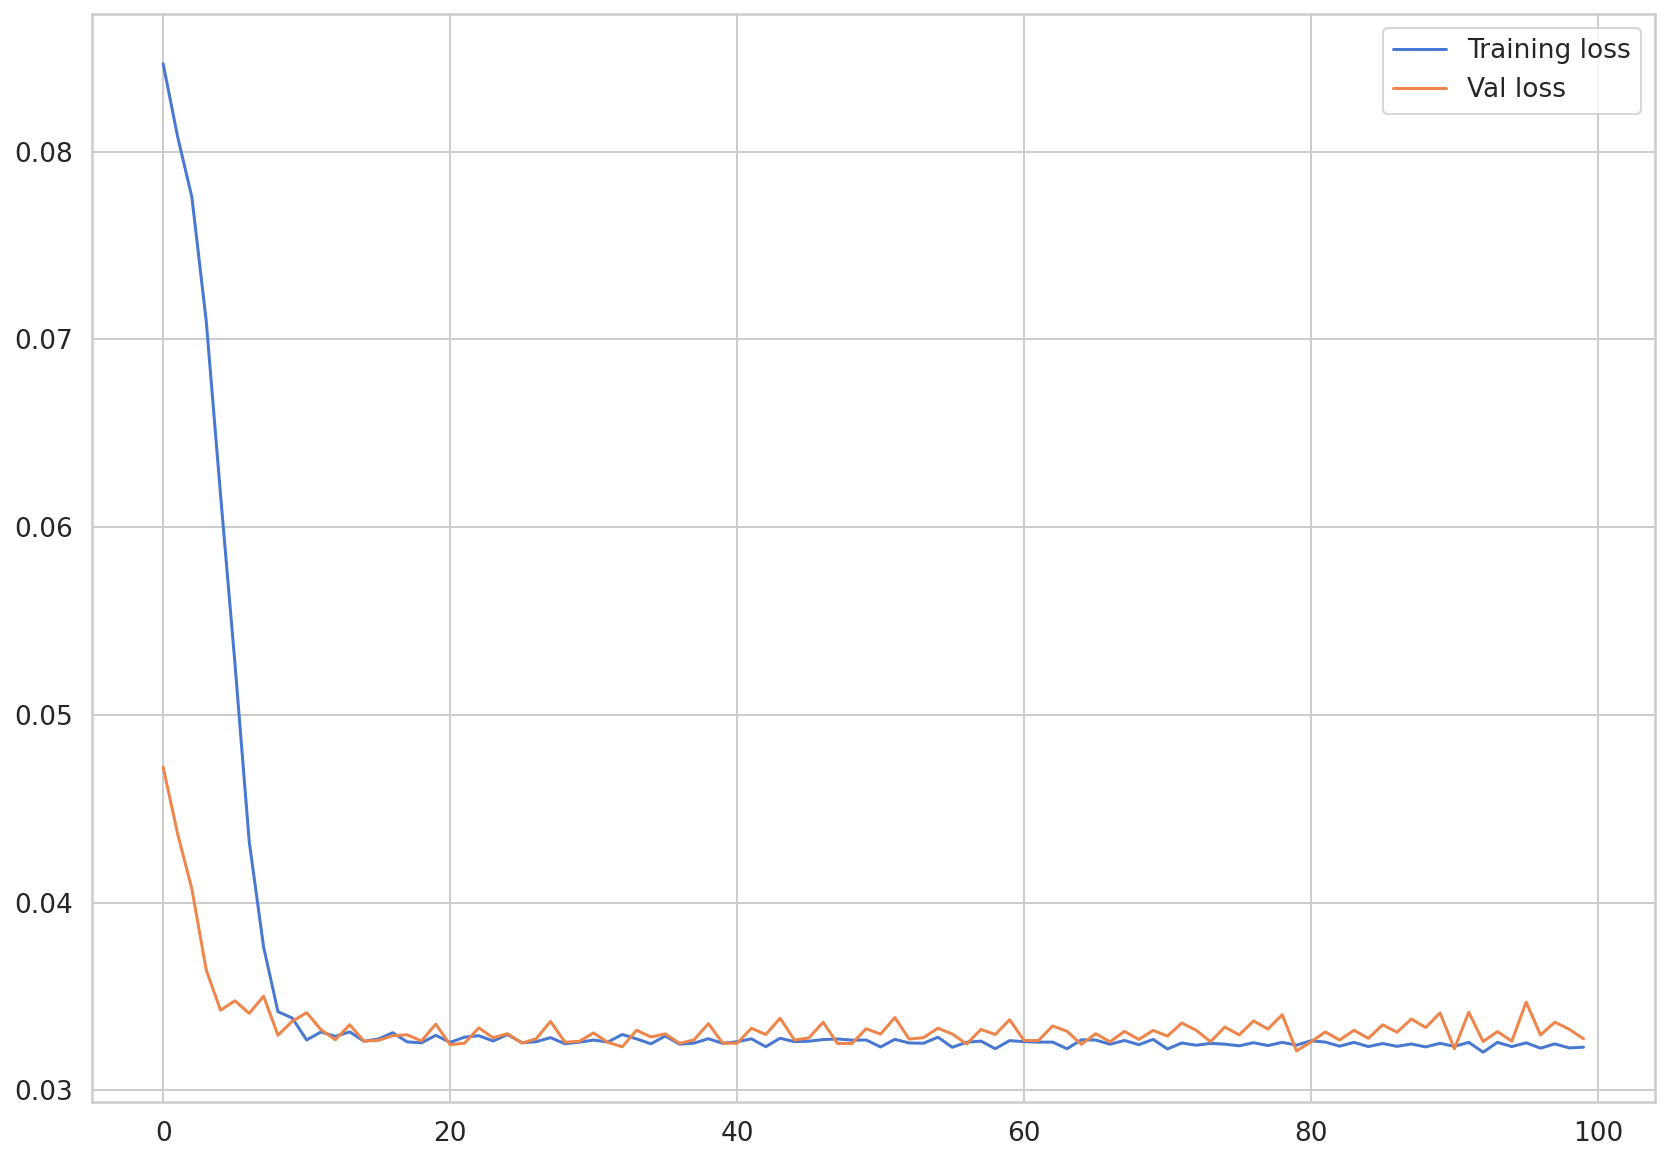

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

## 4.5 예측

앞서 만든 모델의 성능을 확인해보기 위해 시험 데이터에 대한 예측을 진행해보겠습니다. 예측할 때도 새로운 시퀀스가 입력될 때 마다 `hidden_state`는 초기화를 해줘야 이전 시퀀스의 `hidden_state`가 반영되지 않습니다. `torch.unsqueeze` 함수를 사용하여 입력 데이터의 차원을 늘려 모델이 예상하는 3차원 형태로 만들어줍니다. 그리고 예측된 데이터 내에 존재하는 스칼라값만 추출하여 `preds` 리스트에 추가합니다.

In [ ]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

모델이 예측한 값과 실제값과 비교를 진행해보겠습니다. `y_test`에 실제값이 저장돼있으며 현재 스케일링된 상태입니다. 원래 스케일로 변환시켜주기 위해서 아래 산식을 활용하겠습니다. MinMax 스케일링을 적용할 때 사용한 산식을 응용하여 원래 값으로 변환하는 산식입니다. 

>$x = x_{scaled} * (x_{max} - x_{min}) + x_{min}$

이번 데이터에서 $x_{min}$은 0이였습니다. 그러므로 원래 스케일로 복구하기 위해선 $x_{max}$만 곱해주면 됩니다. 

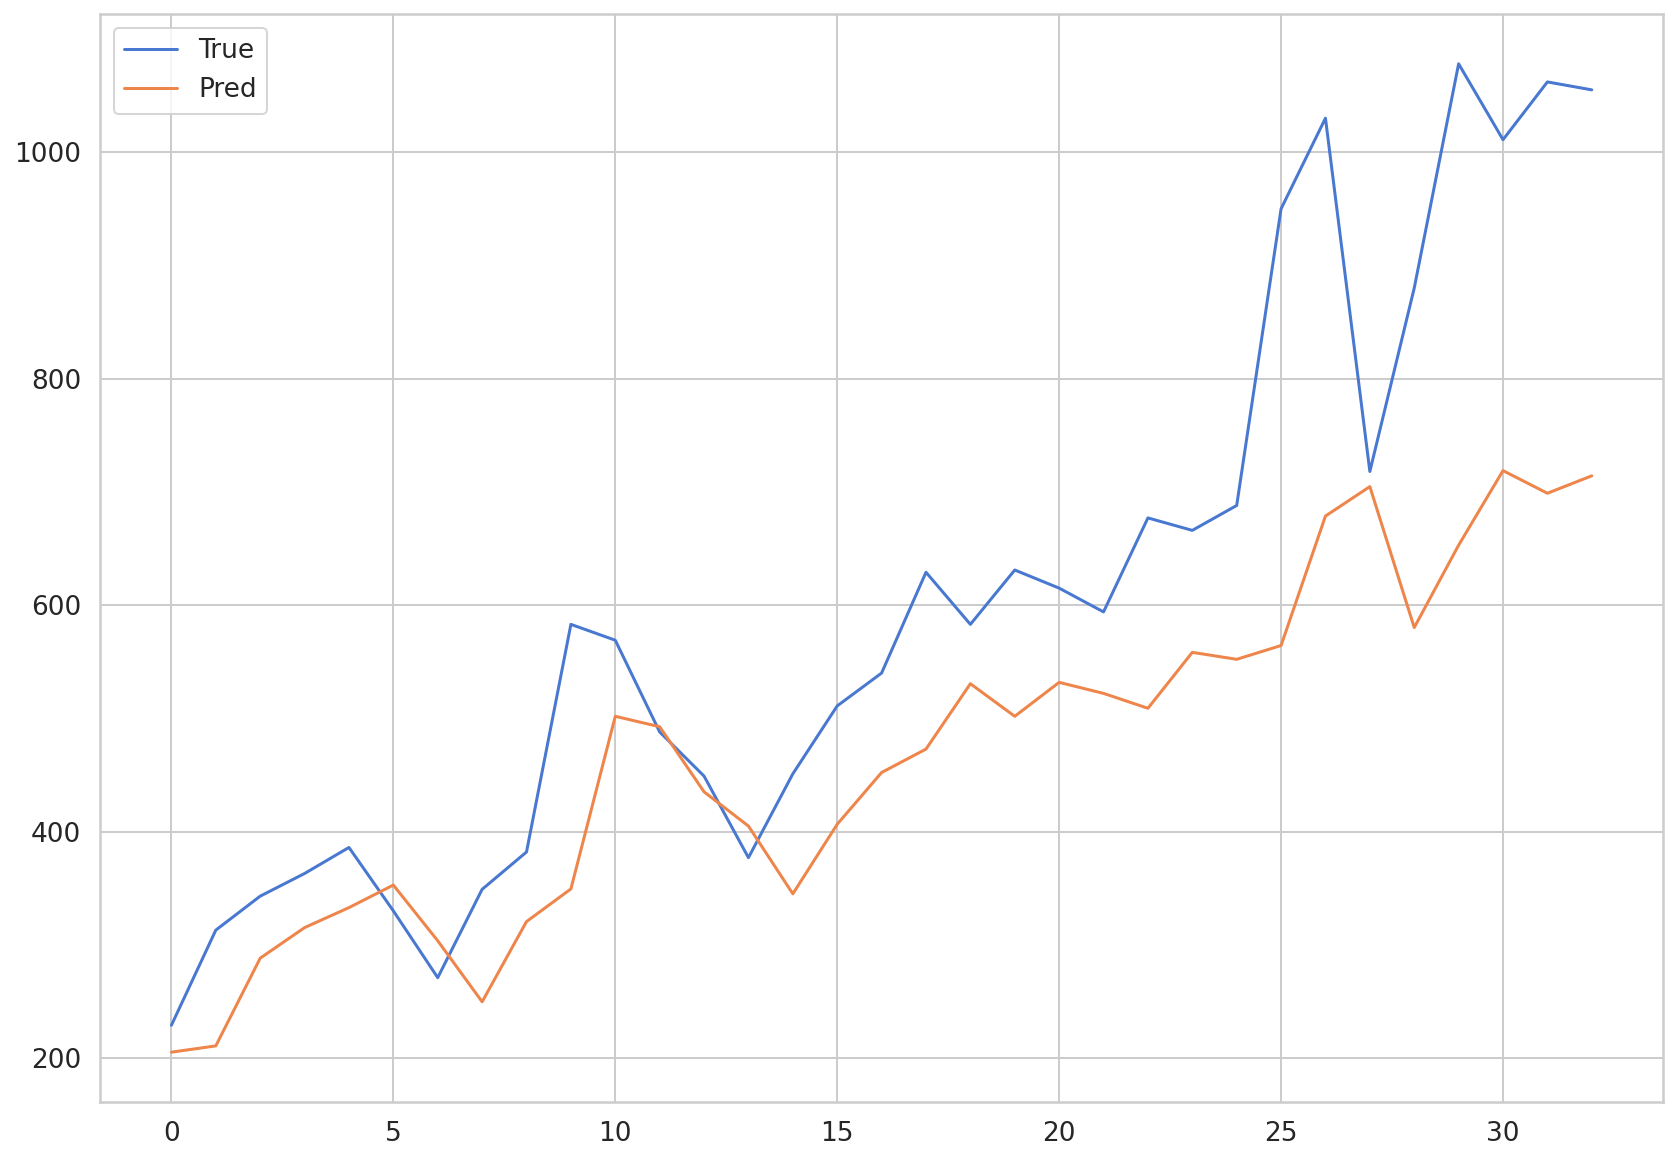

In [ ]:
plt.plot(np.array(y_test) * MAX, label = 'True')
plt.plot(np.array(preds) * MAX, label = 'Pred')
plt.legend()

파란색 그래프는 시험 데이터의 실제값을 나타내며 주황색 그래프는 예측값을 나타냅니다. 확진자가 상승하는 추세는 모델이 예측하고 있지만 확진자가 급격히 증가하는 구간에 대해서는 예측이 잘 되지 않음을 알 수 있습니다. 예측값의 평균 오차를 구하기 위해 MAE 값을 산출해보겠습니다. 

In [ ]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [ ]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

247.31322312245575

시험 데이터에 대한 예측값이 평균적으로 실제값과 약 250명의 차이를 지니고 있다는 것을 알 수 있습니다. 과거 확진자 수 뿐만 아니라 이동성 데이터, 인구 통계 데이터 등을 활용한다면 보다 정교한 예측이 가능할 것으로 보입니다. 

지금까지 코로나 확진자 데이터를 활용해 LSTM 모델 구축 실습을 진행했습니다. 다음 장에서는 CNN-LSTM을 시계열 데이터에 적용해보는 실습을 진행하겠습니다. 